In [1]:
pip install tensorflow_model_optimization

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tempfile
from tensorflow_model_optimization.sparsity import keras as sparsity
import zipfile
import os


In [3]:
train_pd = pd.read_csv('sign_mnist_train.csv')

test_pd = pd.read_csv('sign_mnist_test.csv')

In [4]:
train_pd.shape, test_pd.shape

((27455, 785), (7172, 785))

In [5]:
x_train = train_pd.drop(['label'], axis=1).values
y_train = train_pd['label'].values

In [6]:
x_train.shape, y_train.shape

((27455, 784), (27455,))

In [7]:
x_test = test_pd.drop(['label'], axis=1).values
y_test = test_pd['label'].values

In [8]:
x_test.shape, y_test.shape

((7172, 784), (7172,))

In [9]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# Normalize the input

x_train = x_train/ 255

x_test= x_test/ 255

batch_size= 128

In [10]:
#Build the model

model = keras.Sequential([
    keras.layers.Conv2D(20, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(40, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(80, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(25, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size= batch_size, validation_data=(x_test, y_test))

Epoch 1/30
215/215 [==============================] - 2s 7ms/step - loss: 3.0700 - accuracy: 0.2171 - val_loss: 2.9525 - val_accuracy: 0.3462
Epoch 2/30
215/215 [==============================] - 1s 6ms/step - loss: 2.7537 - accuracy: 0.5439 - val_loss: 2.7255 - val_accuracy: 0.5736
Epoch 3/30
215/215 [==============================] - 1s 6ms/step - loss: 2.5933 - accuracy: 0.7008 - val_loss: 2.6435 - val_accuracy: 0.6488
Epoch 4/30
215/215 [==============================] - 1s 6ms/step - loss: 2.5497 - accuracy: 0.7398 - val_loss: 2.6251 - val_accuracy: 0.6659
Epoch 5/30
215/215 [==============================] - 1s 6ms/step - loss: 2.5382 - accuracy: 0.7490 - val_loss: 2.6270 - val_accuracy: 0.6573
Epoch 6/30
215/215 [==============================] - 1s 6ms/step - loss: 2.5351 - accuracy: 0.7508 - val_loss: 2.6186 - val_accuracy: 0.6708
Epoch 7/30
215/215 [==============================] - 1s 6ms/step - loss: 2.4929 - accuracy: 0.7963 - val_loss: 2.5594 - val_accuracy: 0.7291
Epoch 

In [12]:
loss, acc = model.evaluate(x_test, y_test)

print('test loss: ', loss)
print('test accuracy: ', acc* 100)

225/225 [==============================] - 0s 2ms/step - loss: 2.3718 - accuracy: 0.9149
test loss:  2.3718225955963135
test accuracy:  91.49470329284668


225/225 - 0s - loss: 2.3718 - accuracy: 0.9149

Test accuracy: 91.49470329284668


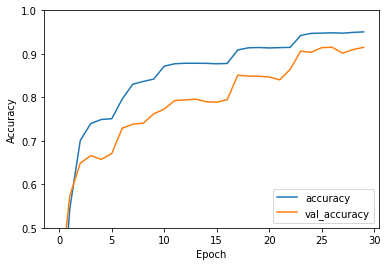

In [13]:
#Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc*100)

In [14]:
_, baseline_model_accuracy = model.evaluate(
    x_test, y_test, verbose=0)

print('Baseline test accuracy %:', baseline_model_accuracy * 100)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy %: 91.49470329284668
Saved baseline model to: /tmp/tmpu2oxn4in.h5


In [15]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 3
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 28, 28, 20)        382       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 20)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 40)        14442     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 40)          1         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 7, 7, 80)          57682     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 3, 3, 80)          1         
_________________________________________________

In [16]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/3
  1/194 [..............................] - ETA: 0s - loss: 2.4872 - accuracy: 0.8125WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
194/194 [==============================] - 3s 13ms/step - loss: 2.3366 - accuracy: 0.9506 - val_loss: 2.3276 - val_accuracy: 0.9574
Epoch 2/3
194/194 [==============================] - 2s 12ms/step - loss: 2.3950 - accuracy: 0.9025 - val_loss: 2.3292 - val_accuracy: 0.9567
Epoch 3/3
194/194 [==============================] - 2s 12ms/step - loss: 2.3526 - accuracy: 0.9416 - val_loss: 2.3285 - val_accuracy: 0.9570


In [17]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy * 100) 
print('Pruned test accuracy:', model_for_pruning_accuracy *100)

Baseline test accuracy: 91.49470329284668
Pruned test accuracy: 91.94087982177734


In [18]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp7mhsycft.h5


In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpg8k1wc_d/assets
Saved pruned TFLite model to: /tmp/tmpp5hlgxci.tflite


In [20]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [21]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 1522188.00 bytes
Size of gzipped pruned Keras model: 490933.00 bytes
Size of gzipped pruned TFlite model: 485267.00 bytes


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmp_zdrxqa2/assets


INFO:tensorflow:Assets written to: /tmp/tmp_zdrxqa2/assets


Saved quantized and pruned TFLite model to: /tmp/tmp8yzqqqg2.tflite
Size of gzipped baseline Keras model: 1522188.00 bytes
Size of gzipped pruned and quantized TFlite model: 135977.00 bytes


In [23]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(x_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == y_test).mean()
  return accuracy

In [26]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)


print('Pruned TFLite test accuracy:', model_for_pruning_accuracy * 100)
print('Pruned and quantized TFLite test_accuracy %:', test_accuracy * 100)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.


Pruned TFLite test accuracy: 91.94087982177734
Pruned and quantized TFLite test_accuracy %: 91.99665365309538
